In [1]:
# You will need to install the sinter, stim, matplotlib, pymatching, and numpy packages!
# Check the STIM Getting Started guide for specific package version dependencies (as there are some specific versions of these that STIM requires)

import stim
import sinter
import pymatching
import matplotlib.pyplot as plt
import numpy as np

# These should be default packages!
import os
from typing import List
from pprint import pprint as pp

# This python script contains some modified IBM Repition Surface Code that allows you to specify a (at least for the moment) a single qubit and individually set it's defect rate
from defective_qubit_surface_code_generator import surface_code_circuit_string

### Demo/Introduction To Code ####

In [2]:
# These are the stats that the surface code circuit string generator can be modified with!
distance = 5
rounds = 1
p = 0.01
p_defective = 0.05
defective_qubit_coordinate = [(3,3)]

circuit = stim.Circuit(surface_code_circuit_string(distance, rounds, p, p_defective, def_coord=[(3,3)]))
sampler = circuit.compile_detector_sampler()

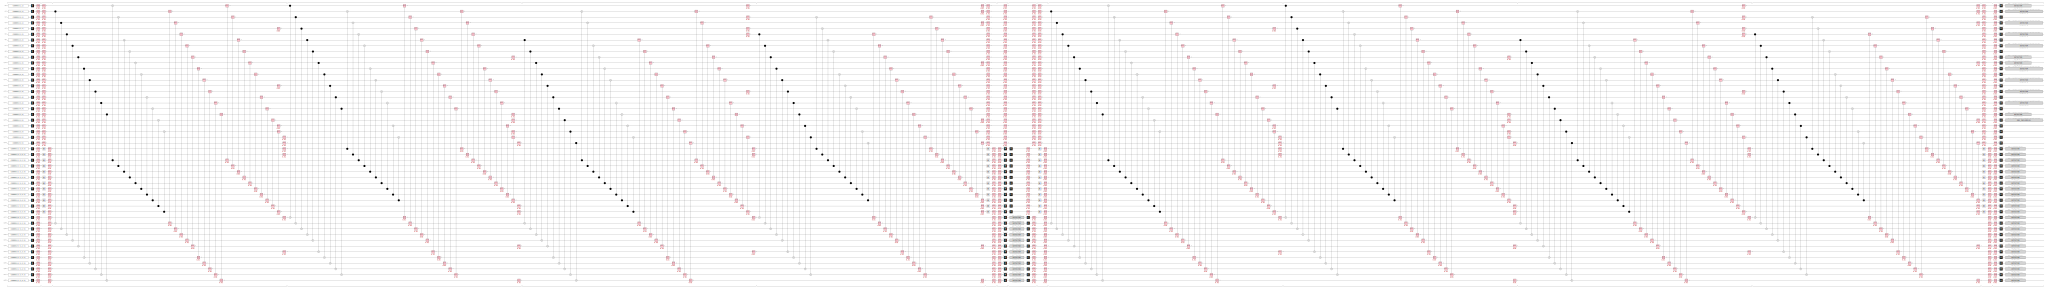

In [3]:
## These diagrams can be viewed as you normally would a STIM circuit!
## If you want to save it as a SVG, you can uncomment out the below file!
circuit.diagram('timeline-svg')

# diagram = circuit.diagram('timeline-svg')
# with open('sc_defect_qubit_timeline_diagram_.svg', 'w') as f:
#     f.write(str(diagram))

##Some additional interesting diagram views worth checking out!

## Very cool little 3-D model for viewing timeslices!
# circuit.diagram("timeline-3d")

## Visualizing the Surface Code Timeslices
# circuit.diagram("detslice-svg")

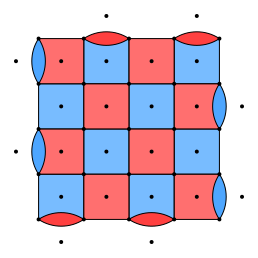

In [4]:
## Visualizing the Surface Code (d = 5)!
circuit.diagram("detslice-svg", tick=8)


In [5]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)
    

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [6]:
# Sinter can be used to easily generate plots over a range of attributes
# Below is a plot for plotting the increase in the defective qubits error rate

# NOTE - very high shots will give very smooth graphs but lessens the helpfulness of the range shading

d = 5
noise_ranges = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
p_defec_ranges = [.05, .10, .15, .20, .25, .30, .35]

tasks = [
    sinter.Task(
        circuit = stim.Circuit(surface_code_circuit_string(distance = 5, rounds=2, p=noise, p_def=p_defec, def_coord=[(2.5,3.5)])),
        json_metadata={'p': noise, 'p_defect': p_defec},
    )
    for noise in noise_ranges
    for p_defec in p_defec_ranges
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=os.cpu_count(),
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=10_000,
)

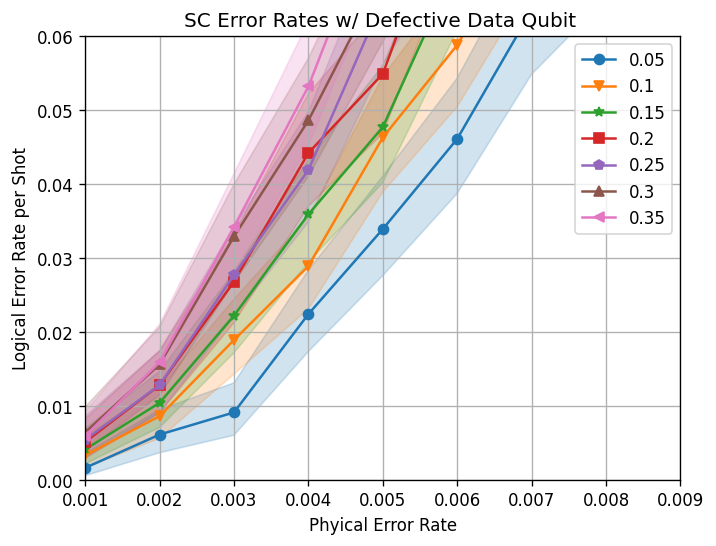

In [7]:
# Sinter can also automatically be used to plot said collected data
# Both the above functions are in functions for conveniently testing and plotting a multitude of configurations

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['p_defect'],
)
# ax.set_ylim(1e-4, 1e-0)
# ax.set_xlim(5e-2, 5e-1)
ax.set_ylim(.0, 0.06)
ax.set_xlim(min(noise_ranges), max(noise_ranges))
# ax.loglog()
ax.set_title(f"SC Error Rates w/ Defective {"Data"} Qubit ")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

### Functions! ####

In [8]:
## Helpers

def get_coord_for_qubit_type(distance, type = 'center'):
    #TODO - add type options for various spaces (i.e. edge data qubit or edge measure qubit)
    match type:
        case 'center':
            return (int((distance + 1)/2), int((distance+1)/2))
        case 'measure-center':
            return (int((distance + 1)/2) + 0.5, int((distance+1)/2) + 0.5)
        case _:
            #TODO - throw error here probably
            return None


In [9]:
# get_coord_for_qubit_type(9, 'center')
type('measure-center') == str

True

In [10]:
## Data Examination Convenience Functions
# Plotting Logical Error Rate by Physical Error Rate over various Defective Qubit Error Rates
def sc_defect_sinter_stats(_distance, _defect_coord, _p_defect_range, _noise_range = None, _rounds = 3, _max_shots = 50_000):
    if not _noise_range: 
        _noise_range = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]

    if type(_defect_coord) == str: 
        defect_type = _defect_coord
        _defect_coord = get_coord_for_qubit_type(_distance, _defect_coord)
    else:
        #TODO - better handling for this once more defect_type shortcut strings are added, fine for now idk
        defect_type = 'Center'
    print(f"Defective Qubit At -> {_defect_coord}")
    tasks = [
        sinter.Task(
            circuit = stim.Circuit(surface_code_circuit_string(distance = _distance, 
                                                               rounds=_rounds, 
                                                               p=noise, 
                                                               p_def=p_defec, 
                                                               def_coord=[_defect_coord])),
            json_metadata={'p': noise, 'p_defect': p_defec, 'coords': _defect_coord, 'distance': _distance, 'rounds': _rounds, 'defect_type': defect_type},
        )
        for noise in _noise_range
        for p_defec in _p_defect_range
    ]

    collected_stats: List[sinter.TaskStats] = sinter.collect(
        num_workers=os.cpu_count(),
        tasks=tasks,
        decoders=['pymatching'],
        max_shots=_max_shots,
    )

    return collected_stats

# Plotter
def sc_defect_sinter_plot(_collected_stats, x_range = None, y_range = None, use_loglog = False, defec_coords = None):
    fig, ax = plt.subplots(1, 1)

    # NOTE - if you want to change this function to use these stats below as part of the graph function
    # you will need to handle this differently as these are currently static across all tasks and thus all
    # tasks will have the same value for these in this case #

    # defect_cord = _collected_stats[0].json_metadata['coords']
    dist = _collected_stats[0].json_metadata['distance']
    rounds = _collected_stats[0].json_metadata['rounds']
    defect_type = _collected_stats[0].json_metadata['defect_type']

    defect_cord = get_coord_for_qubit_type(dist, defect_type)
    sinter.plot_error_rate(
        ax=ax,
        stats=_collected_stats,
        x_func=lambda stats: stats.json_metadata['p'],
        group_func=lambda stats: stats.json_metadata['p_defect'],
    )
    if y_range: 
        ax.set_ylim(y_range[0], y_range[1]) 
    if x_range: 
        ax.set_xlim(x_range[0], x_range[1])
    if use_loglog: 
        ax.loglog()
    # ax.spines['left'].set_position('zero')
    # ax.spines['bottom'].set_position('zero')
    ax.set_title(f"Surface Code Error Rates w/ \n d = {dist}; r = {rounds}; Defect {'Data' if defect_cord[0]%1 == 0 or defect_cord[1]%1 == 0 else 'Measure'} Qubit = {defect_cord}")
    ax.set_xlabel("Phyical Error Rate")
    ax.set_ylabel("Logical Error Rate per Shot")
    ax.grid(which='major')
    ax.grid(which='minor')
    ax.legend()
    fig.set_dpi(120)  # Show it bigger

In [11]:
#Plotting Logical Error Rate By Defective Qubit Error Rate
def sc_sinter_stats_pdef_over_distance(_distances, _defect_type = 'center', _noise = 0.001, _rounds_lambda = None, _max_shots = 50_000):
    #scaler for allowing custom round scaling based on distance
    if not _rounds_lambda: _rounds_lambda = lambda d: d*3

    #TODO - add dynamic setting based on parameter
    p_defec_values = [round((x/100), 2) for x in range(5, 95, 5)]
    p_defec_min_max = [min(p_defec_values), max(p_defec_values)]

    #TODO - set rounds such that lower code distances have more rounds to smooth out line and higher distances progressively have less rounds (also shortens time)
    # but check if this impacts the calculations at all or skews it unnecessarily.#
    tasks = [
        sinter.Task(
            circuit = stim.Circuit(surface_code_circuit_string(distance=d, rounds=d*3, p=_noise, p_def=p_defec, def_coord=[get_coord_for_qubit_type(d, _defect_type)])),
            json_metadata={'p': _noise, 'p_defect': p_defec, 'coords': get_coord_for_qubit_type(d, _defect_type), 'distance': d, 'rounds':_rounds_lambda(d), 'defect_type': _defect_type, "p_defect_range": p_defec_min_max},
        )
        for p_defec in p_defec_values
        for d in _distances
    ]

    collected_stats: List[sinter.TaskStats] = sinter.collect(
        num_workers=os.cpu_count(),
        tasks=tasks,
        decoders=['pymatching'],
        max_shots=_max_shots,
    )

    return collected_stats

def plot_sc_defect_logical_by_p_defect(_collected_stats, x_range = None, y_range = None, use_loglog = False):
    fig, ax = plt.subplots(1, 1)

    # Pull static values from collected stats metadata
    defect_type = _collected_stats[0].json_metadata['defect_type']
    defect_error_range = _collected_stats[0].json_metadata['p_defect_range']

    sinter.plot_error_rate(
        ax=ax,
        stats=_collected_stats,
        x_func=lambda stats: stats.json_metadata['p_defect'],
        group_func=lambda stats: stats.json_metadata['distance'],
    )
    if y_range: ax.set_ylim(y_range[0], y_range[1]) 
    if x_range: 
        ax.set_xlim(x_range[0], x_range[1])
    else:
        ax.set_xlim(defect_error_range[0], defect_error_range[1])
    if use_loglog: ax.loglog()

    #TODO - add specifying for type of qubit (i.e., center, edge)
    type = 'Center'

    ax.set_title(f"Surface Code Error Rates w/ \n {type} Defect {'Data' if defect_type == 'center' else 'Measure'} Qubit by Code Distance")
    ax.set_xlabel("Error Rate of Defective Qubit")
    ax.set_ylabel("Logical Error Rate per Shot")
    ax.grid(which='major')
    ax.grid(which='minor')
    ax.legend()
    fig.set_dpi(120)  # Show it bigger

### Graph Sets ###

#### Demo Graphs ####

Defective Qubit At -> (3, 3)


TypeError: 'NoneType' object is not subscriptable

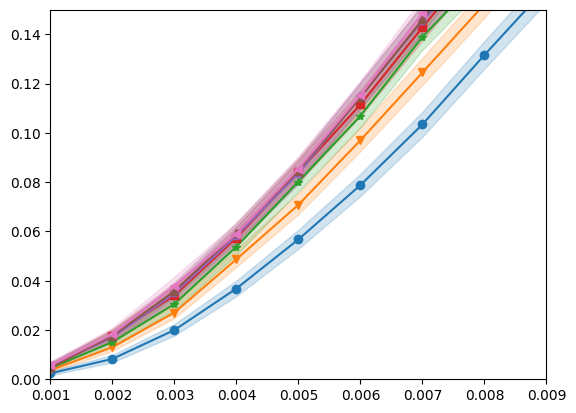

In [12]:
# Graphing d = 5 code over a wide range of p_defect values

# Surface Code, d = 5, Center Data Qubit, Def P Range .05 -> .65
d = 5
defec_coords = (3,3)
p_defec_ranges = [.05, .15, .25, .35, .45, .55, .65]
collected = sc_defect_sinter_stats(d, defec_coords, p_defec_ranges, _rounds=3)
# collected = sc_defect_sinter_stats(5, 'center', [.05, .15, .25, .35, .45, .55, .65])

sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])

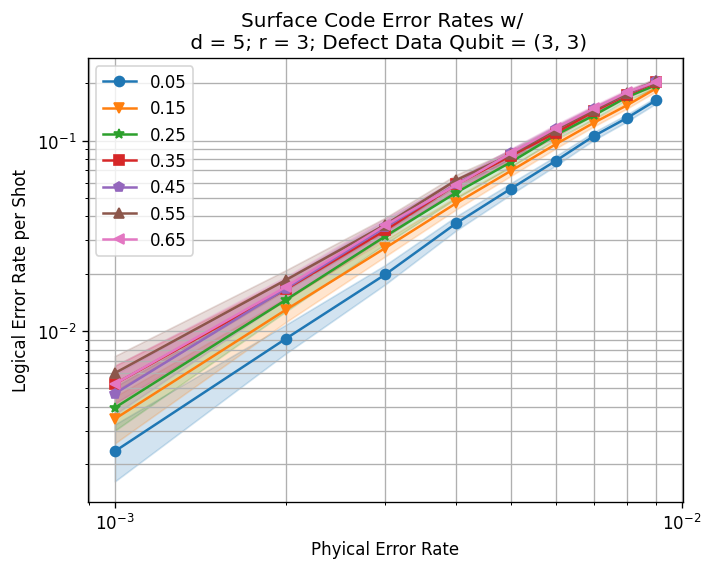

In [ ]:
# Same graph as above with log x & log y
sc_defect_sinter_plot(collected, use_loglog=True)

#### **Set 1** - Logical Error Rate by Physical Error Rate for distance 5, 7, 9, 11, 13 w/ Center Qubit Defective (P Defective between .05 & .35) ####

In [ ]:
#Defective Error Rates for this Set test
p_defec_ranges = [.05, .10, .15, .20, .25, .30, .35]

Defective Qubit At -> (3, 3)


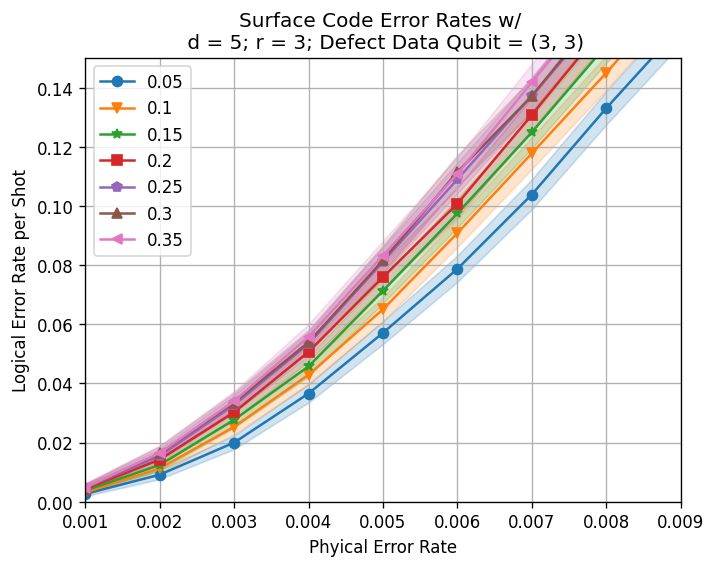

In [ ]:
# Surface Code, d = 5, Center Data Qubit
d = 5
collected = sc_defect_sinter_stats(d, 'center', [.05, .10, .15, .20, .25, .30, .35])
sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])
# sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.06])

Defective Qubit At -> (4, 4)


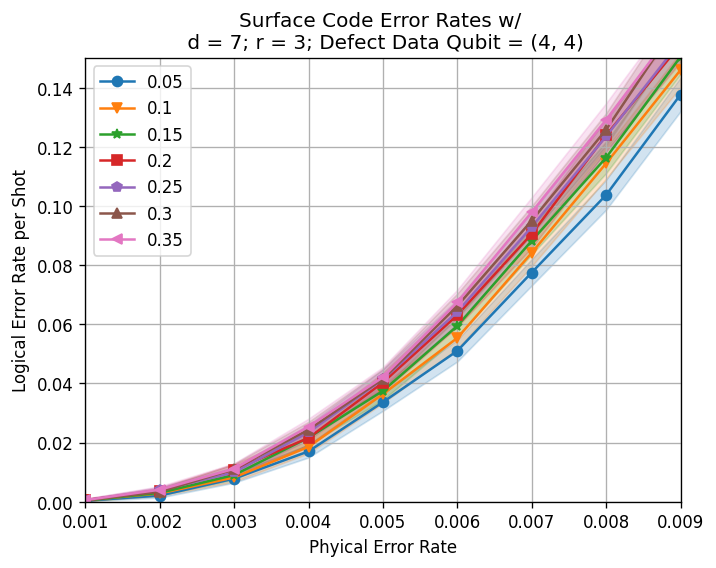

In [ ]:
# Surface Code, d = 7, Center Data Qubit
d = 7
collected = sc_defect_sinter_stats(d, 'center', p_defec_ranges, _rounds=3)
sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])

Defective Qubit At -> (5, 5)


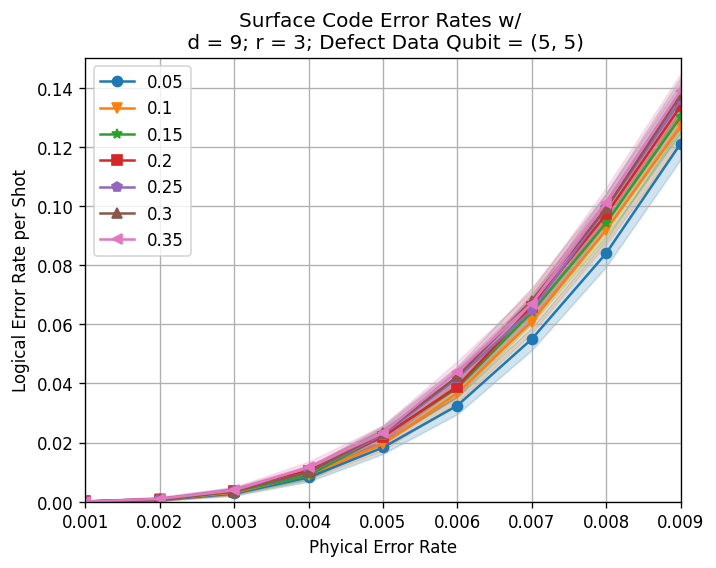

In [ ]:
# Surface Code, d = 9, Center Data Qubit
d = 9
collected = sc_defect_sinter_stats(d, 'center', p_defec_ranges, _rounds=3)
sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])

Defective Qubit At -> (6, 6)


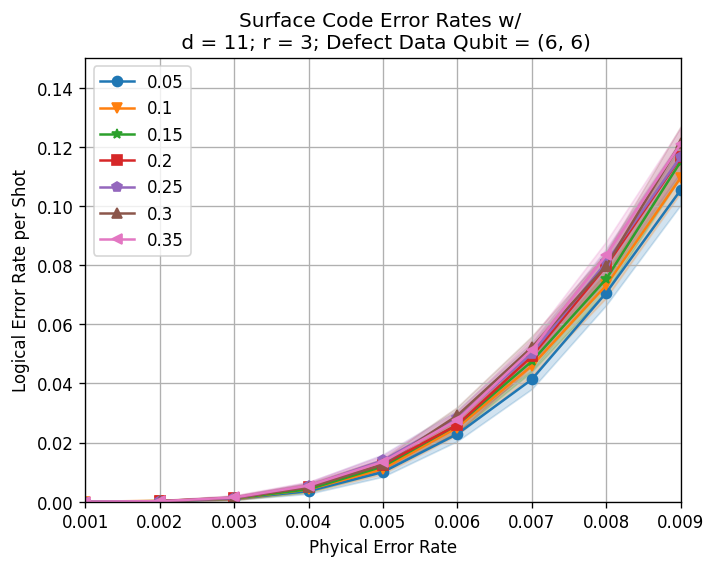

In [ ]:
# Surface Code, d = 11, Center Data Qubit
d = 11
collected = sc_defect_sinter_stats(d, 'center', p_defec_ranges, _rounds=3)
sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])

Defective Qubit At -> (7, 7)


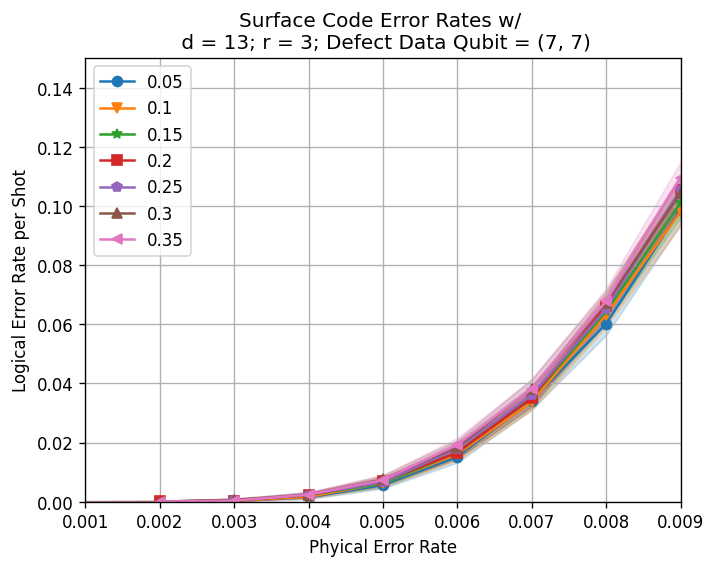

In [ ]:
# Surface Code, d = 13, Center Data Qubit
d = 13
collected = sc_defect_sinter_stats(d, 'center', p_defec_ranges, _rounds=3)
sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])

#### **Set 1.5** - Logical Error Rate by Physical Error Rate for distance 5, 7, 9, 11, 13 w/ Measure Qubit Defective (P Defective between .05 & .35) ####

In [ ]:
#Defective Error Rates for this Set test
p_defec_ranges = [.05, .10, .15, .20, .25, .30, .35]

Defective Qubit At -> (3.5, 3.5)


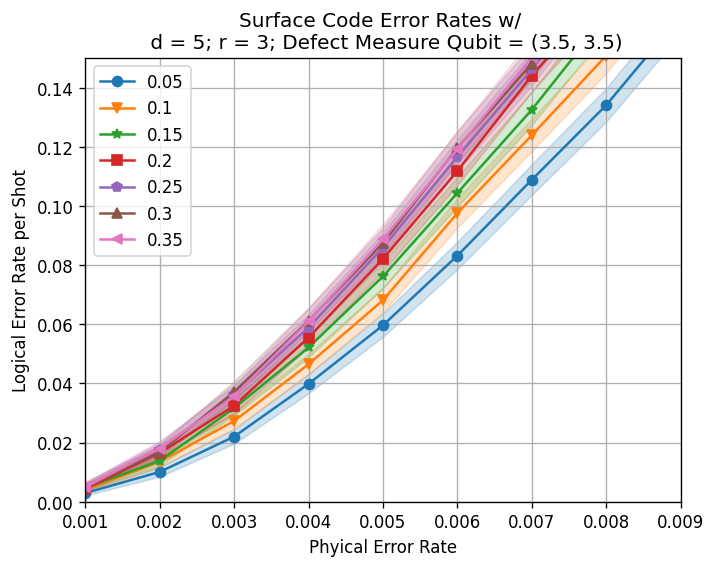

In [ ]:
# Surface Code, d = 5, Center Measure Qubit
d = 5
collected = sc_defect_sinter_stats(d, 'measure-center', [.05, .10, .15, .20, .25, .30, .35])
sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])

Defective Qubit At -> (4.5, 4.5)


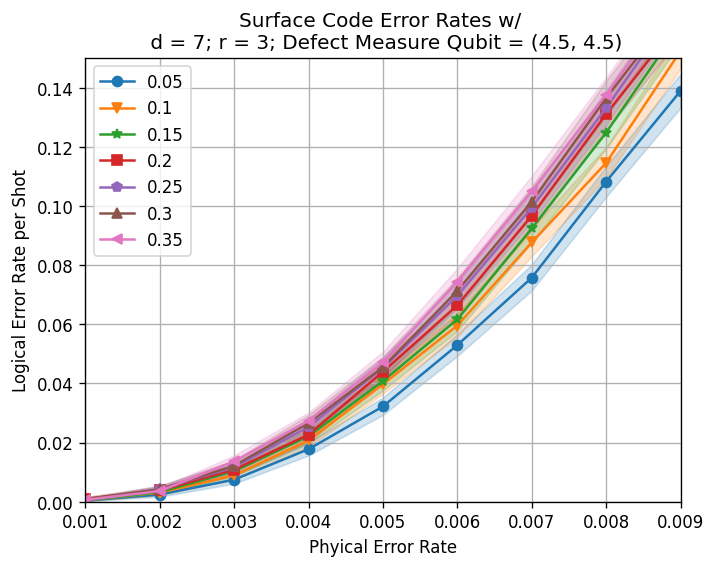

In [ ]:
# Surface Code, d = 7, Center Measure Qubit
d = 7
collected = sc_defect_sinter_stats(d, 'measure-center', [.05, .10, .15, .20, .25, .30, .35])
sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])

Defective Qubit At -> (5.5, 5.5)


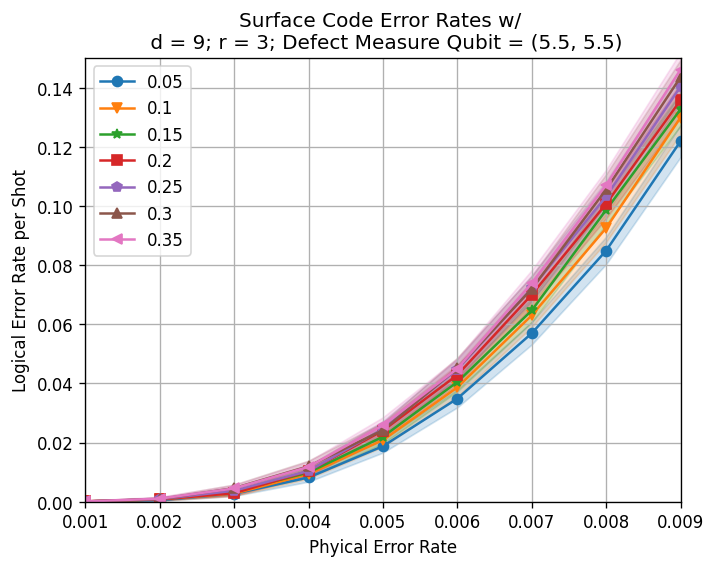

In [ ]:
# Surface Code, d = 9, Center Measure Qubit
d = 9
collected = sc_defect_sinter_stats(d, 'measure-center', [.05, .10, .15, .20, .25, .30, .35])
sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])

Defective Qubit At -> (6.5, 6.5)


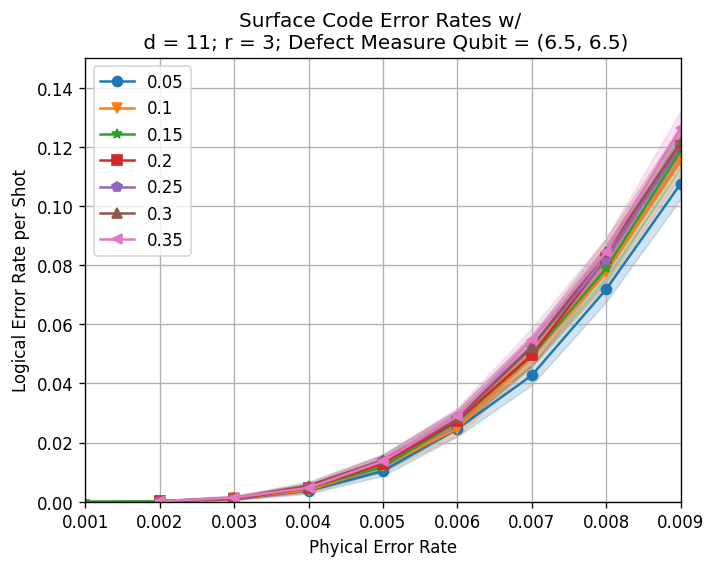

In [ ]:
# Surface Code, d = 11, Center Measure Qubit
d = 11
collected = sc_defect_sinter_stats(d, 'measure-center', [.05, .10, .15, .20, .25, .30, .35])
sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])

Defective Qubit At -> (7.5, 7.5)


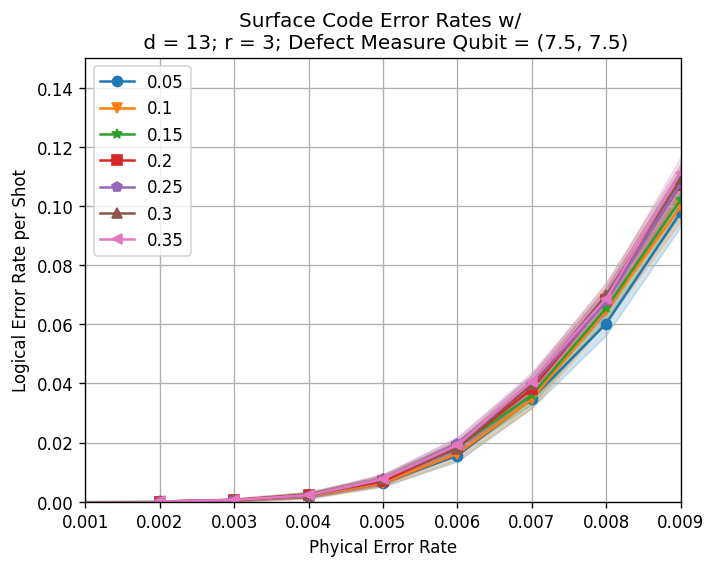

In [ ]:
# Surface Code, d = 13, Center Measure Qubit
d = 13
collected = sc_defect_sinter_stats(d, 'measure-center', [.05, .10, .15, .20, .25, .30, .35])
sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])

Defective Qubit At -> (8.5, 8.5)


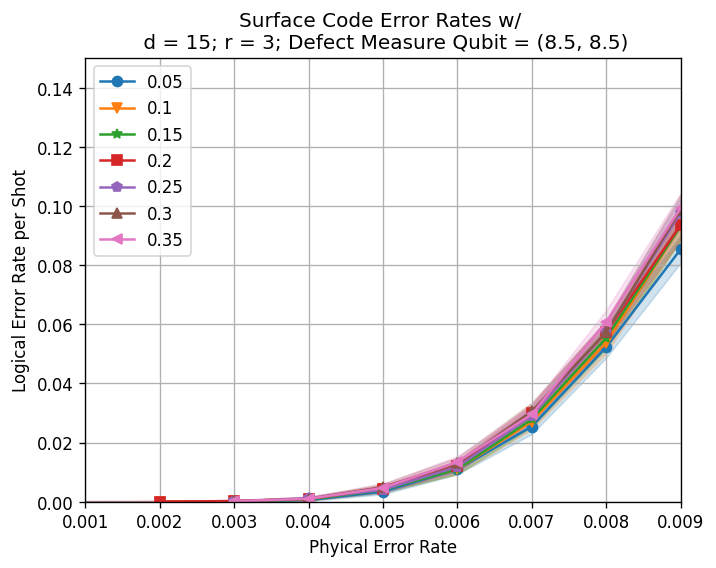

In [13]:
# Surface Code, d = 15, Center Measure Qubit
d = 15
collected = sc_defect_sinter_stats(d, 'measure-center', [.05, .10, .15, .20, .25, .30, .35])
sc_defect_sinter_plot(collected, x_range=[0.001, 0.009], y_range=[0.00, 0.15])

#### Set 2 - Logical Error Rate by Defective Qubit Error over Code Distances ####

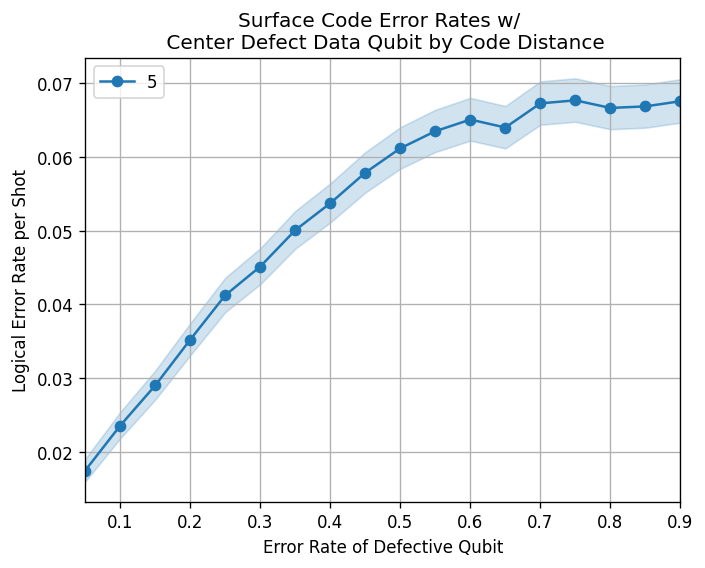

In [ ]:
# Testing over just distance 5 for center
collected = sc_sinter_stats_pdef_over_distance([5], 'center', _max_shots=100_000)
plot_sc_defect_logical_by_p_defect(collected)

(7, 7)


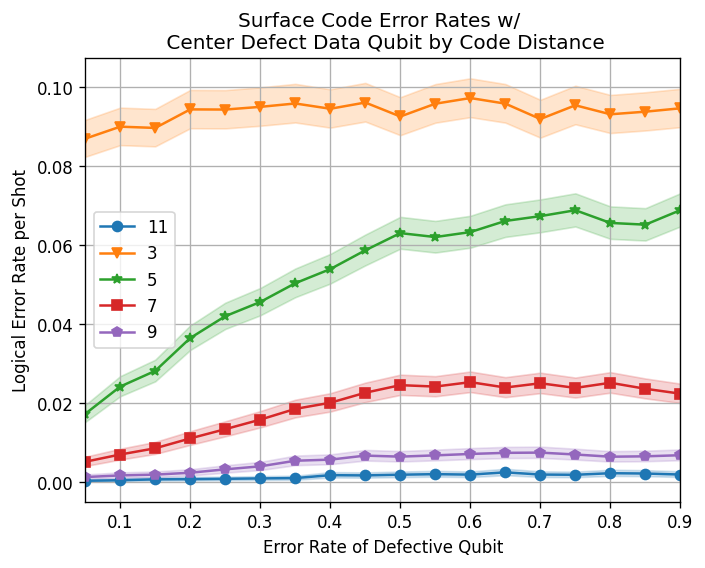

In [ ]:
# Plotting over five code distances
collected = sc_sinter_stats_pdef_over_distance([3, 5, 7, 9, 11])
plot_sc_defect_logical_by_p_defect(collected)

# NOTE - this results in pretty shakey low distances

(7, 7)


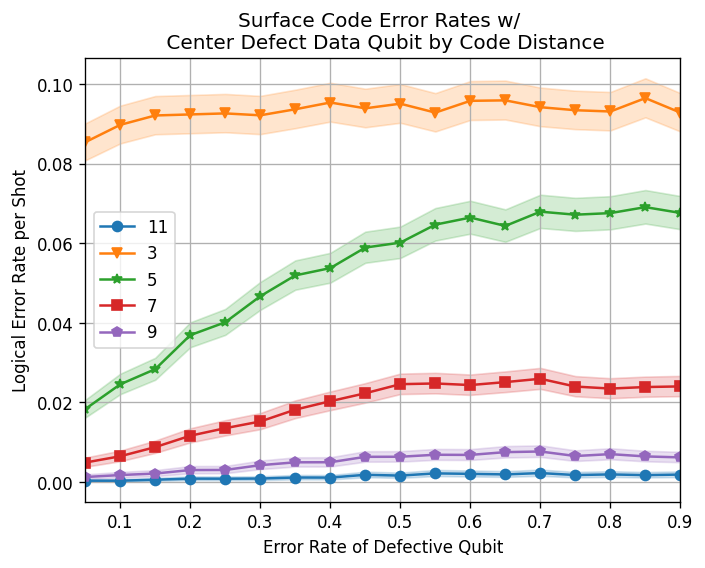

In [ ]:
# Plotting over same five code distances w/ round scaling to give it an asymptotic curve 
# NOTE - this doesnt appear to affect our measured x functions, but the inverse asymptotic curve here allows lower code distances to have higher rounds
collected = sc_sinter_stats_pdef_over_distance([3, 5, 7, 9, 11], _rounds_lambda=lambda x:round((3.67/d)*100))
plot_sc_defect_logical_by_p_defect(collected)

(7, 7)


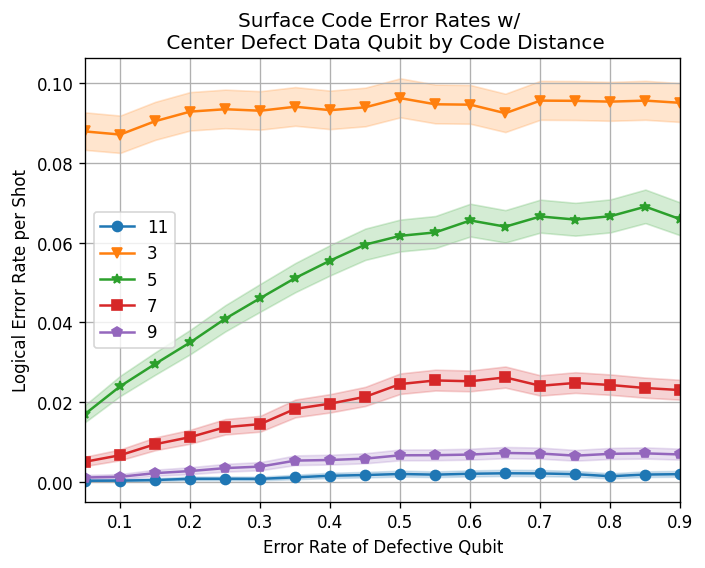

In [ ]:
#This is about the same as above for all of them just smoother!
collected = sc_sinter_stats_pdef_over_distance([3, 5, 7, 9, 11], _rounds_lambda=lambda x:round((4/d)*150))
plot_sc_defect_logical_by_p_defect(collected)

(7, 7)


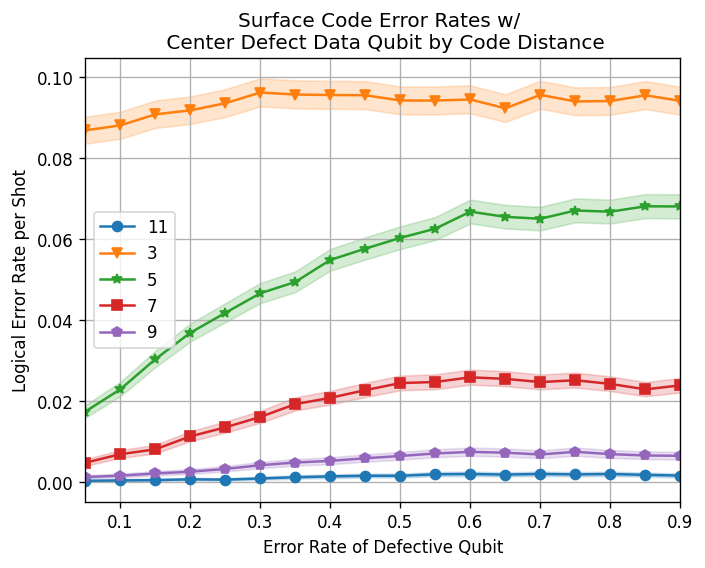

In [ ]:
# Same as above but with default rounds = (distance * 3) and 100,000 shotd

collected = sc_sinter_stats_pdef_over_distance([3, 5, 7, 9, 11], _rounds_lambda=lambda x:round((4/d)*150), _max_shots=100_000)
plot_sc_defect_logical_by_p_defect(collected)